# concrete.biopython, practical applications

**concrete.biopython** is a FHE library based on python [**biopython**](https://biopython.org/) library. It implements the same objects and functions when they are compatible with fhe.

In bioinformatics, the most basic object is the **sequence**. Sequences generally reprensent **DNA** and **RNA** strands, or **proteins** which are **amino acids** strands. Bioinformatics computations are most often processings of such sequences. This tutorial presents some basic processing algorithms on sequences, in FHE. We will first see how to make reusable code to easily generate circuits than can be used for different applications.

Indeed, using FHE for processing biological sensitive data such as human DNA garanties full end to end privacy of the data and of its processing, which is a major issue in the field of biology.

## I. Setting up FHE for practical applications

Before presenting the algorithms, we will set up some reusable code that will help us for each application later.

### Imports
First of all, we need to import **numpy** and **concrete.fhe**, as well as <span style="color:green">**Seq**</span>  from **Bio.Seq**.
Then we import <span style="color:orange">**FheSeq**</span> from **concrete_biopython.FheSeq**, and also **SeqWrapper.**<span style="color:#5CC8FF">**SeqWrapper**</span> which will allow to interface the two librairies.

You can check out the quickstart tutorial presenting these objects in more details. Here, we will follow a similar route than in the quickstart to interface **Bio.Seq** and **concrete_biopython.FheSeq** objects.

In [33]:
import numpy as np
import numpy as np
from concrete import fhe
from Bio.Seq import Seq

import sys, os
sys.path.append(os.path.dirname(os.getcwd()))

from concrete_biopython.FheSeq import FheSeq
from concrete_biopython.SeqWrapper import SeqWrapper


### Sequence preprocessing

As in the quickstart tutorial, we will need to convert <span style="color:green">**Seq**</span> objects from outside FHE to <span style="color:orange">**FheSeq**</span> objects inside the FHE circuit.  

For each pratictal applications, we will have different numbers of <span style="color:green">**Seq**</span> objects to encrypt and process. In order to be able to reuse our code for these multiple applications, we can merge these sequences into one long sequence, so that our circuit takes only one input sequence every time.

Let's define a `concat_sequences` function that concatenates a list of sequences and returns the concatenated sequence, along with indices to be able to slice concatenated sequence back later. Let's also define the reverse function `slice_sequence` to slice back a long sequence into several sequences:

In [40]:
def concat_sequences(seqs):
    """
    Concatenate sequences from a list and records indices as slice objects
    """
    slices=[]
    seq=Seq('')
    index=0
    for s in seqs:
        seq = seq+s # Seq objects can be directly added
        slices.append(slice(index, index+len(s)))
        index+=len(s)
    return seq, slices

def slice_sequence(seq, slices):
    """
    Slice a sequence into its original sub-sequences
    """
    seqs=[]
    index=0
    for ind in slices:
        seqs.append(seq[ind.start:ind.stop])
    return seqs

# testing the functions
SEQ, INDICES = concat_sequences([Seq('AB'), Seq('C'), Seq('DEF')])
print(SEQ)
print(slice_sequence(SEQ, INDICES))

ABCDEF
[Seq('AB'), Seq('C'), Seq('DEF')]


### Making a circuit factory for reusing code

We want to make a circuit factory so that for each application later, we can simply provide a core sequence processing function and provide it to the factory that will generate a circuit from it. We will even wrap this circuit to be able to work with <span style="color:green">**Seq**</span> objects inputs instead of integer arrays inputs.

The core function will be named `process_sequence`, taking a sequence and returning the result of some processing algorithm. We want a function that can work on both clear or encrypted data, so we also provide it with the library **numpy** or **concrete.fhe** for when there are differences in the processing.

For now, we define a simple processing function for the example, that outputs wether two sequences are identical. It first slices the input sequence into two sequences, and then compares them:

In [41]:
def process_sequence(seq, lib=fhe):
    """
    Check wether the two first subsequences are identical, for test
    """
    seqlist = slice_sequence(seq, INDICES)
    return seqlist[0]==seqlist[1]

OUTPUT_PYTHON = process_sequence(SEQ, np)
print("Are the first two sequences equal ?: ", OUTPUT_PYTHON)

Are the first two sequences equal ?:  False


Now let's make a **circuit factory** returning a circuit compiled on a given sequence processing function, and working with an integer array input of given lenght. Note that the integer array input `data` is first converted into a <span style="color:orange">**FheSeq**</span> objects so that the sequence processing function can work on it the same way it works on <span style="color:green">**Seq**</span> objects:

In [44]:
def circuit_factory(input_length, process_seq):
    """
    Return a circuit compiled on 'process_seq' with input lenght 'input_lengt'
    """
    compiler = fhe.Compiler(lambda data: process_seq(FheSeq(data)), {"data": "encrypted"})    
    return compiler.compile(
        inputset=[
        # Use SeqWrapper.maxInteger() to know the maximal integer possible in inputs
        np.random.randint(0, SeqWrapper.maxInteger()+1, size=(input_length,))
        for _ in range(100)
        ],
        configuration=fhe.Configuration(
            enable_unsafe_features=True,
            use_insecure_key_cache=True,
            insecure_key_cache_location=".keys",
            dataflow_parallelize=False, # setting it to True makes the jupyter kernel crash
        ),
        verbose=False,
    )

Then, we make a circuit wrapper that allows to run a circuit onto a <span style="color:green">**Seq**</span> object, using the <span style="color:#5CC8FF">**SeqWrapper**</span>**.toIntegers** function. Here, we will need the wrapper to return **integer outputs**, but we could have converted them back into a <span style="color:green">**Seq**</span> object if needed using <span style="color:#5CC8FF">**SeqWrapper**</span>**.toSeq**.

In [45]:
def circuit_wrapper(circuit, seq, simulate=False):
    """
    Wrap a fhe circuit in order to input Bio.Seq objects, and simulate if needed
    """
    # convert Seq object to integers with SeqWrapper.toIntegers
    integers = SeqWrapper(seq).toIntegers()
    # run the circuit on integer inputs
    integer_output = circuit.simulate(integers) if simulate else circuit.encrypt_run_decrypt(integers)
    # return the integers output
    return integer_output
    # alternatively, one could return a Seq objects with: return SeqWrapper(integer_output).toSeq()

Finally, in order to keep reusing code, we can pack the actual making and running of a circuit in a function, along with printing the output and displaying computation time:

In [47]:
import time

def compute_fhe_output(seq, process_seq, simulate, message):
    """
    Pack up the creation and running of a circuit,
    and display the result along with the computation time
    """
    start = time.time()
    output_fhe = circuit_wrapper(circuit_factory(len(seq),process_seq), seq, simulate)
    end = time.time()
    
    print(message, output_fhe)
    print(f"(took {end - start:.2f} seconds)")

That's it ! Before starting our first practical application, we can try out this code on our test sequence and processing function defined earlier, checking homomorphically wether the two first sequences of the list are identical:

In [48]:
# compute our simple process_sequence function in FHE on our test sequence:
compute_fhe_output(SEQ, process_sequence, simulate=False, message='Are the first two sequences equal ?: ')

Are the first two sequences equal ?:  0
(took 0.89 seconds)


## Levenstein distance

## II. Computing the hamming distance between two sequences

As a first simple application, we will compute in FHE the [**hamming distance**](https://en.wikipedia.org/wiki/Hamming_distance) between two sequences. The **hamming distance** between two sequences of same length is simply the number of positions where the two sequences are different. It is often used in bioinformatics to measure the similarity of biological sequences such as **DNA** strands.  



In [76]:
def hamming(arr1, arr2):
    """
    Returns the number of differences between arrays arr1 and arr2
    """
    if arr1.size != arr2.size:
        raise ValueError('arrays must have same size')
        
    return np.sum(arr1 != arr2)

def hamming_adapter(seq1, seq2, lib=fhe):
    """
    Adapter for hamming distance of Seq objects
    """
    if lib is fhe:
        return hamming(seq1.toArray(),seq2.toArray())
    else:
        return hamming(np.array(list(seq1.__str__())), np.array(list(seq2.__str__())))

In [77]:
S = Seq("AGGTTGGTAAAATGGTCCGTGGC")
T = Seq("ACCGTAATAAACGTGTCCGTTGG")

SEQ_H, INDICES_H = concat_sequences([S,T])
print(SEQ_H)

AGGTTGGTAAAATGGTCCGTGGCACCGTAATAAACGTGTCCGTTGG


In [78]:
def process_sequence(seq, lib=fhe):
    seqlist = slice_sequence(seq, INDICES_H)
    return hamming_adapter(seqlist[0],seqlist[1], lib)

In [79]:
OUTPUT_PYTHON = process_sequence(SEQ_H, np)
print('Haming distance of S & T:', OUTPUT_PYTHON)

Haming distante of S & T: 10


In [48]:
# now we can run our circuit on Seq objects and compare the result with output_seq
compute_fhe_output(SEQ_H, process_seq, simulate=False, message='Haming distance of S & T: ')


The sorted indices of sequences are :  10
(took 3.144 seconds)


## Finding the origin of replication in a sequence

In [25]:
def min_two(x, y):
    diff = y - x
    min_xy = y - fhe.univariate(lambda x: 0 if x < 0 else x)
    return min_xy

In [29]:
# Function to find the minimum skew

## FHE LIMITATION: only one minimum can be found

def minimum_skew(seq,lib=fhe):
    if lib is fhe:
        CG_integers = SeqWrapper(Seq('CG')).toIntegers()
        letter_table = [0]*(SeqWrapper.maxInteger()+1)
        letter_table[CG_integers[0]]=-1
        letter_table[CG_integers[1]]=1
        letter_table = fhe.LookupTable(letter_table)
        skew_counts = fhe.zeros(len(seq))
    else:
        letter_table = {'A':0, 'C':-1, 'G':1, 'T':0}
        skew_counts = np.zeros(len(seq)).astype('int')
        
    skew_counts[0] = letter_table[seq[0]]
    minimum = skew_counts[0]
    min_index = 0
    for i in range(1,len(seq)):
        # compute cumulated sum
        skew_counts[i] = skew_counts[i-1] + letter_table[seq[i]]
        # and keep minimum
        ismin = (skew_counts[i]<minimum)
        minimum = skew_counts[i]*ismin + minimum*(1-ismin)
        #minimum = min_two(skew_counts[i], minimum)
        min_index = i*ismin + min_index*(1-ismin)
        
    return min_index, skew_counts


In [30]:
SEQ_O = Seq('ACGTGAGGTACGATCGCATACCACTGACGACCATAACCCAGACCACCCCATAGCCAGAGATCGATTGAGATGAGGCCCAGTTAGGGACAG')

OUTPUT_PYTHON, skew_counts = minimum_skew(SEQ_O, np)
print('The minimum skew is at index: ', OUTPUT_PYTHON)

The minimum skew is at index:  54


Text(0.5, 0, 'Index of DNA')

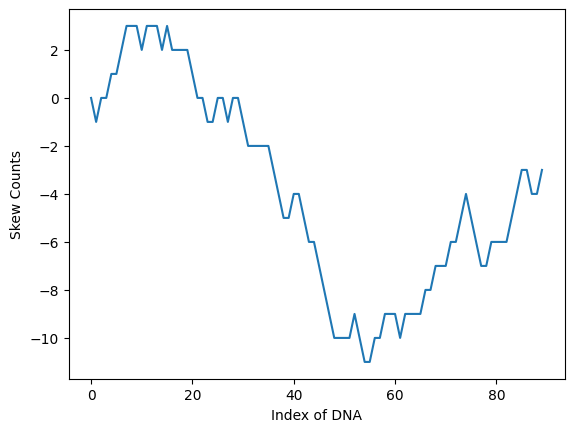

In [31]:
# Plot the skew_counts to check them out
import matplotlib.pyplot as plt
plt.plot(skew_counts)
plt.ylabel('Skew Counts')
plt.xlabel('Index of DNA')

In [32]:
def process_sequence(seq, lib=fhe):
    return minimum_skew(seq, lib)[0] # return only the minimum value for fhe

compute_fhe_output(SEQ_O, process_sequence, simulate=True, message='The minimum skew is at index: ')

The minimum skew is at index:  54
(took 14.272 seconds)


## Comparing sequences

## Sorting sequences

In [12]:
def sort_rank(seqlist, lib=fhe):
    n=len(seqlist)
    # create comparison matrix
    comp_matrix = lib.zeros((n,n))
    # fill the matrix with results of seqlist[i]>seqlist[j]
    for i in range(0, n):
        for j in range(i+1, n):
            # compute upper half of the matrix
            comp_matrix[i,j] = (seqlist[i]<seqlist[j])
            # then copy the opposite to the lower half because the matrix is antisymetrical
            comp_matrix[j,i] = 1-comp_matrix[i,j] # this counts seqlist[j]>=seqlist[i]
    # now sum up each row to get a sorting rank for the sequences
    return np.sum(comp_matrix, axis=0)
            
     
def process_seq(seq, lib=fhe):
    seqlist = slice_sequence(seq, INDICES_S)
    return sort_rank(seqlist, lib)

In [13]:
SEQ1 = Seq('AA')
SEQ2 = Seq('AAA')
SEQ3 = Seq('AAB')
SEQ4 = Seq('CAA')

SEQ_S, INDICES_S = concat_sequences([SEQ3, SEQ4, SEQ1, SEQ2])
print(SEQ_S)

OUTPUT_PYTHON = process_sequence(SEQ_S, np)
print("The sorted indices of sequences are :", OUTPUT_PYTHON)

AABCAAAAAAA
The sorted indices of sequences are : [2. 3. 0. 1.]


In [99]:
# now we can run our circuit on Seq objects and compare the result with output_seq
compute_fhe_output(SEQ_S, process_seq, simulate=False, message='The sorted indices of sequences are: ')


The sorted indices of sequences are:  [2 3 0 1]
(took 6.812 seconds)


array([2, 3, 0, 1], dtype=uint64)

In [101]:
SEQ1 = Seq('ACGATAGAGATAACCCGTACAGAACT')
SEQ2 = Seq('GGGCAGATATAGATTTAGCATAGTT')
SEQ3 = Seq('ACGGCATACAGCGGTTCAGAGACTA')
SEQ4 = Seq('AGGGCAGCAGAGCAGAGAGACAGAC')

SEQ_S, INDICES_S = concat_sequences([SEQ3, SEQ4, SEQ1, SEQ2])
print(SEQ_S)

# now we can run our circuit on Seq objects and compare the result with output_seq
compute_fhe_output(SEQ_S, process_sequence, simulate=False, message='The sorted indices of sequences are: ')


ACGGCATACAGCGGTTCAGAGACTAAGGGCAGCAGAGCAGAGAGACAGACACGATAGAGATAACCCGTACAGAACTGGGCAGATATAGATTTAGCATAGTT


KeySetCache: miss, regenerating .keys/13593486136536055049/0_0


The sorted indices of sequences are:  [1 2 0 3]
(took 40.465 seconds)


array([1, 2, 0, 3], dtype=uint64)